In [27]:
def get_tag_files(tag_path, suffix='csv'):
    
    tag_path = Path(tag_path)
    all_files = [str(tag_file) for tag_file in tag_path.rglob('*.' + suffix)]
    
    return all_files

tag_files = get_tag_files(tag_path)

In [34]:
def create_csv_paths(data_types, base='', exp='', full=True):
    
    csv_paths = {}
    
    for data_type in data_types:

        if not full:
            csv_dir = '../data/2016_2019/samples/'
            e = '_' + str(base) + 'e' + str(exp)
            csv_path = csv_dir + data_type + e + '.csv'
        else:
            csv_dir = '../data/2016_2019/full/'
            e = ''
            csv_path = csv_dir + data_type + e + '.csv'
            
        csv_paths[data_type] = csv_path
    
    return csv_paths

data_types = ['answers', 'comments', 'notes', 'questions', 'users', 'wikis', 'tags']
csv_paths = create_csv_paths(data_types)

In [261]:
# DATA
import pandas as pd
import numpy as np


# SYSTEM
import os, sys
from pathlib2 import Path

# MISC 
import re
import csv
from itertools import izip

# PLOTTING
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [36]:
data_type = 'users'

sample = False

m = 25
exp = 2

if sample:
    csv_dir = '../data/2016_2019/samples/'
    e = '_' + str(m) + 'e' + str(exp)
    csv_path = csv_dir + data_type + e + '.csv'
else:
    csv_dir = '../data/2016_2019/full/'
    e = ''
    csv_path = csv_dir + data_type + e + '.csv'

data_types = ['answers', 'comments', 'notes', 'questions', 'users', 'wikis', 'paths', 'tags', 'node_tags', 'terms']
csv_paths = create_csv_paths(data_types)

tag_dir =  '../data/2016_2019/full/tags'
tag_files = get_tag_files(tag_dir)

# print csv_paths

## LOAD TAG USAGE AND TERM DATA

In [32]:
# LOAD CSV'S INTO DATAFRAME DROP DATE (DATAPOINT IS NO LONGER AVAILABLE COULD BE MERGED IN A FUTURE WITH MORE TIME)
use_cols = ['nid', 'uid', 'tid']
tag_dfs = [pd.read_csv(tag_file, usecols=use_cols) for tag_file in tag_files]

# REORDER TAG DF COLUMNS IN PREP WITH TERM DATA MERGE
tag_dfs = [tag_df[use_cols] for tag_df in tag_dfs]

# CONCAT THE FRAMES INTO ONE BIG ONE
tag_usage = pd.concat(tag_dfs)

# CHECK OUT THE RESULTS!
tag_usage.sample(10)

,nid,uid,tid
5389,523,1,14336
584,13702,420056,1009
1825,12966,468990,14
6313,16853,545097,17997
10522,18842,580718,19940
20525,11802,319070,11684
8546,12916,461120,1697
3655,19056,584260,13971
17235,12331,46902,8709
6255,12204,1,15113


In [365]:
# tag_usage.loc[tag_usage['uid'] == 461120]
tag_usage = tag_usage.loc[tag_usage['uid'] != 461120]

In [39]:
# LOAD TERM DATA
use_cols = ['tid', 'name', 'count']
terms = pd.read_csv(csv_paths['terms'], usecols=use_cols)
terms.sample(10)

,tid,name,count
7121,14388,enterprise,4.0
7165,14432,writer,2.0
7183,14450,redirect:13450,1.0
5404,12671,environmentaljustice,8.0
8771,16039,raspberry-pi-spectrometer,17.0
2699,7026,monitoring,28.0
6374,13641,date:12-28-2016,1.0
3691,10074,lon:-74.14529577537604,1.0
12219,19487,main,1.0
10770,18038,lead-testing,10.0


## PARSE TERM DATA

In [44]:
# MARK POWER TAGS
terms['power'] = terms['name'].str.contains(':')
terms.loc[terms['power'] == True].head()

,tid,name,count,power
754,2349,events:boston,5.0,True
755,2350,list:plots-boston,3.0,True
756,2360,events:new-york-city,12.0,True
757,2361,list:plots-nyc,1.0,True
763,2369,list:plots-gulfcoast,1.0,True


In [192]:
# https://stackoverflow.com/a/41320210/6023530
print 'ROWS WITH NAN\'S:', '\n'
print 'TID:', terms['tid'].isnull().sum(), '\n', 'NAME:', terms['name'].isnull().sum()
print 'COUNT:', terms['count'].isnull().sum(), '\n', 'POWER:', terms['power'].isnull().sum()

ROWS WITH NAN'S: 

TID: 0 
NAME: 2
COUNT: 214 
POWER: 2


In [193]:
# REMOVE ROWS W/O A NAME B/C THEN NO TAG TO APPLY FUNCTION TO
terms.dropna(subset=['name', 'power'], inplace=True)

In [163]:
# https://www.geeksforgeeks.org/python-pandas-split-strings-into-two-list-columns-using-str-split/
# https://stackoverflow.com/a/35373340/6023530

def split_power_tags(row):
    
    split_row = row['name'].split(':')#, n=1, expand=True)
    
    if len(split_row) == 2: 
        row['name'] = split_row[1]
        row['power_type'] = split_row[0]
    else:
        row['power_type'] = 'npt'
    
    return row['name'], row['power_type']

power_test = terms.sample(20).copy()
power_test['name'], power_test['power_type'] = izip(*power_test.apply(split_power_tags, axis=1))
power_test = power_test[['tid', 'name', 'power_type', 'count', 'power']]
power_test.head()

In [164]:
power_test.head()

,tid,name,count,power,power_type
3769,10152,130.8757748325563,1.0,True,lon
12409,19677,8.496973,1.0,True,lon
11964,19232,image,1.0,False,npt
8254,15522,software-outreach,2.0,True,activity
5612,12879,barnraising-2015,20.0,False,npt


In [180]:
terms.iloc[-20:-15] # GOOD BUT REPEATABLE MIX OF POWER/NON-POWER

,tid,name,count,power
13047,20315,laga,1.0,False
13048,20316,redirect:pipeline-webinar,1.0,True
13049,20317,psn,1.0,False
13050,20318,activity:thermal-flashlight-assembly,5.0,True
13051,20319,pirateship,1.0,False


In [195]:
terms['name'], terms['power_type'] = izip(*terms.apply(split_power_tags, axis=1))
terms = terms[['tid', 'name', 'power_type', 'count', 'power']]

In [196]:
# O. M. G. It wooorked!
terms.iloc[-20:-15]

,tid,name,power_type,count,power
13047,20315,laga,npt,1.0,False
13048,20316,pipeline-webinar,redirect,1.0,True
13049,20317,psn,npt,1.0,False
13050,20318,thermal-flashlight-assembly,activity,5.0,True
13051,20319,pirateship,npt,1.0,False


## MERGE WITH TAG USAGE

In [203]:
print tag_usage.shape[0]
tag_usage.tail(5)

54004


,nid,uid,tid
5073,14247,508251,15019
5074,14487,508247,15020
5075,14496,441262,15022
5076,14496,441262,15023
5077,14496,441262,15024


In [237]:
print 'ROWS WITH NAN\'S:', '\n'
print 'NID:', tag_usage['nid'].isnull().sum()
print 'UID:', tag_usage['uid'].isnull().sum()
print 'TID:', tag_usage['tid'].isnull().sum()

ROWS WITH NAN'S: 

NID: 0
UID: 0
TID: 0


In [204]:
print terms.shape[0]
terms.tail(5)

13065


,tid,name,power_type,count,power
13062,20330,phun,npt,1.0,False
13063,20331,sprinkler,npt,1.0,False
13064,20332,trung,npt,1.0,False
13065,20333,10.823098,lat,1.0,True
13066,20334,106.629663,lon,1.0,True


In [243]:
# https://stackoverflow.com/a/12098586/6023530
selection = list(terms.iloc[-20:-15]['tid'])
tag_usage[tag_usage['tid'].isin(selection)]

print 'LEFT (MANY) \n', tag_usage[tag_usage['tid'].isin(selection)], '\n'
print 'RIGHT(ONE) \n', terms.iloc[-20:-15], '\n'

# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#brief-primer-on-merge-methods-relational-algebra
# merged = pd.merge(tag_usage, terms, on='tid', how='left')

print 'MERGED'
print merged[merged['tid'].isin(selection)].drop('power', axis=1), '\n'

print 'TOTALS \n'
print 'TAG USAGE:', '\t', tag_usage.shape[0], tag_usage.shape[1]
print 'TERMS:', '\t\t', terms.shape[0], terms.shape[1]
print 'MERGED:', '\t', merged.shape[0], merged.shape[1]

LEFT (MANY) 
         nid     uid    tid
10989  19111  584933  20315
10990  18421       1  20316
10991  19113  584971  20317
10992    625       1  20318
10993   9922       1  20318
10994  11581       1  20318
10995    627       1  20319 

RIGHT(ONE) 
         tid                         name power_type  count  power
13047  20315                         laga        npt    1.0  False
13048  20316             pipeline-webinar   redirect    1.0   True
13049  20317                          psn        npt    1.0  False
13050  20318  thermal-flashlight-assembly   activity    5.0   True
13051  20319                   pirateship        npt    1.0  False 

MERGED
         nid     uid    tid                         name power_type  count
48908  19111  584933  20315                         laga        npt    1.0
48909  18421       1  20316             pipeline-webinar   redirect    1.0
48910  19113  584971  20317                          psn        npt    1.0
48911    625       1  20318  thermal-f

In [321]:
merged.to_csv(csv_paths['tags'], index=False)
tags = pd.read_csv(csv_paths['tags'])
tags[tags['tid'].isin(selection)]

,nid,uid,tid,name,power_type,count,power
48908,19111,584933,20315,laga,npt,1.0,False
48909,18421,1,20316,pipeline-webinar,redirect,1.0,True
48910,19113,584971,20317,psn,npt,1.0,False
48911,625,1,20318,thermal-flashlight-assembly,activity,5.0,True
48912,9922,1,20318,thermal-flashlight-assembly,activity,5.0,True
48913,11581,1,20318,thermal-flashlight-assembly,activity,5.0,True
48914,627,1,20319,pirateship,npt,1.0,False


## SEPPERATE POWER TAG TYPES

In [351]:
power_tag_counts = tags['power_type'].value_counts().reset_index()
power_tag_counts.columns = ['power_type', 'count']
# power_tag_counts = power_tag_counts[['power_type', 'count']]
power_tag_counts.head(20)
# power_tag_counts[20:40]

,power_type,count
0,npt,44866
1,question,2389
2,activity,1126
3,lat,988
4,lon,979
5,response,810
6,parent,361
7,with,350
8,barnstar,240
9,event,211


In [344]:
#

# ['question', 'activity', 'with', 'barnstar' 'event', 'replication', 'place',  ]

# LIST: GOOGLE GROUP TAGS, list:plots-spectrometry
# WITH: THE USERS WHO ALSO WROTE THE NOTE, with:bsugar
# BARNSTAR: CONTENT AWARDED A BARNSTAR


# https://stackoverflow.com/a/38309823/6023530
# tags.loc[tags['power_type'] == 'barnstar'].groupby('name')['nid'].nunique()#value_counts

,power_type,count
0,npt,44866
1,question,2389
2,activity,1126
3,lat,988
4,lon,979
5,response,810
6,parent,361
7,with,350
8,barnstar,240
9,event,211


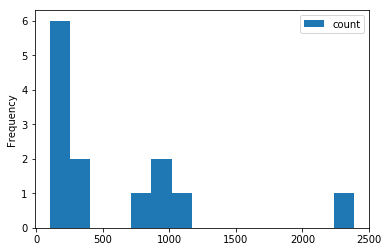

In [329]:
count_gt_one = (power_tag_counts['count'] > 100)
not_npt = (power_tag_counts['power_type'] != 'npt')
filtered = power_tag_counts.loc[count_gt_one & not_npt]
filtered.plot(kind='hist', bins=15)
# plt.show()

In [352]:
power_categories = ['question', 'activity', 'with', 'barnstar' 'event', 'replication', 'place']

# LIST: GOOGLE GROUP TAGS, list:plots-spectrometry
# WITH: THE USERS WHO ALSO WROTE THE NOTE, with:bsugar
# BARNSTAR: CONTENT AWARDED A BARNSTAR

# COMBINE TWO CATEGORIES
# tags.loc[tags['power_type'] == 'activities', 'power_type'] = 'activity'
# tags.loc[tags['power_type'] == 'events', 'power_type'] = 'place'

# https://stackoverflow.com/a/38309823/6023530
tags.loc[tags['power_type'] == 'events'].groupby('name')['nid'].nunique()#value_counts

In [353]:
power_categories = ['question', 'activity', 'with', 'barnstar' 'event', 'replication', 'place']

power_tag_counts[power_tag_counts['power_type'].isin(power_categories)]

# power_tag_counts = tags['power_type'].value_counts().reset_index()

,power_type,count
1,question,2389
2,activity,1126
7,with,350
11,replication,197
12,place,153
